Adapted from [Data visualization and investigation](https://www.kaggle.com/davids1992/data-visualization-and-investigation) by *DavisS*.

Making sure the examples work for me ...

# 0. Setup

Explore code for displaying waveform and spectogram

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

Math

In [2]:
import librosa
import numpy    as np

from scipy.fftpack         import fft
from scipy                 import signal
from scipy.io              import wavfile
from sklearn.decomposition import PCA

Visualization

In [3]:
import matplotlib.pyplot as plt
import pandas            as pd

import seaborn           as sns
import IPython.display   as ipd
import librosa.display

import plotly.offline    as py
import plotly.graph_objs as go
import plotly.tools      as tls

py.init_notebook_mode(connected=True)

%matplotlib inline

# 1. Visualization

There are two theories of a human hearing - place (frequency-based) and temporal) In speech recognition, I see two main tendencies - to input spectrogram (frequencies), and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients, PLP. You rarely work with raw, temporal data.

Let's visualize some recordings!

### 1.1 Wave file

In [4]:
%%time
train_audio_path = '../../input/train/audio/'
filename = str(train_audio_path) + 'yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(filename)

Wall time: 0 ns


In [5]:
sample_rate

16000

With *sample_rate* of 16 kHz, frequencies as high as 8 kHz can be detected according to the Nyquist theorem.

In [6]:
samples

array([ 14,  -7, -14, ...,  19,  20,  27], dtype=int16)

In [7]:
len(samples)

16000

In [8]:
def plotRawWave(plotTitle, sampleRate, samples, figWidth=14, figHeight=4):
    plt.figure(figsize=(figWidth, figHeight))
    plt.plot(np.linspace(0, sampleRate/len(samples), sampleRate), samples)
    plt.title("Raw sound wave of " + plotTitle)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [sec]")
    return None

### 1.2 Compute spectrogram

Define function that computes a spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear. We need to assure that there are no 0 values as input to logarithm.

In [9]:
def computeLogSpectrogram(audio, sampleRate, windowSize=20, stepSize=10, epsilon=1e-10):
    nperseg  = int(round(windowSize * sampleRate / 1000))
    noverlap = int(round(stepSize   * sampleRate / 1000))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sampleRate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + epsilon)

In [10]:
def plotLogSpectrogram(plotTitle, freqs, times, spectrogram, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
               cmap="inferno",   #  default was "viridis"  (perceptually uniform)
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.colorbar(pad=0.01)
    plt.title('Spectrogram of ' + plotTitle)
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [sec]")
    fig.tight_layout()
    return None

If we use spectrogram as an input features for a neural network, we need to standardize features. (We need to standardize over all the dataset, here's example just for one, which doesn't give good mean and std!)

### 1.3 Compute Mel Spectrum

From [Wikipedia](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum): 

* *In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.*

* *A cepstrum is the result of taking the inverse Fourier transform (IFT) of the logarithm of the estimated spectrum of a signal.*

See [details about MFCC](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

The MEL power spectrogram and MFCC can be computed using the python librosa package.  See [Librosa demo](https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb).

paper:  [librosa: Audio and Music Signal Analysis in Python](http://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf)

**Compute and Plot Mel Spectrum**

In [11]:
def computeLogMelSpectrogram(samples, sampleRate, nMels=128):
    melSpectrum = librosa.feature.melspectrogram(samples, sr=sampleRate, n_mels=nMels)
    
    # Convert to dB, which is a log scale.  Use peak power as reference.
    logMelSpectrogram = librosa.power_to_db(melSpectrum, ref=np.max)
    
    return logMelSpectrogram

Visualize short-term fourier transform (STFT) power spectrum

In [12]:
def plotLogMelSpectrogram(plotTitle, sampleRate, logMelSpectrum, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(logMelSpectrum, sr=sampleRate, x_axis='time', y_axis='mel')
    plt.title('Mel log-frequency power spectrogram: ' + plotTitle)
    plt.colorbar(pad=0.01, format='%+02.0f dB')
    plt.tight_layout()    
    return None

### 1.4 Mel-frequency cepstral coefficients

Using pre-computed log-power Mel spectrogram.  See [info](https://librosa.github.io/librosa/generated/librosa.feature.mfcc.html).

Notes from [Replicating Research: Feature Vectors of Audio Samples](https://dsp.stackexchange.com/questions/36925/replicating-research-feature-vectors-of-audio-samples):

The question was about [A Dataset and Taxonomy for Urban Sound Research](https://serv.cusp.nyu.edu/projects/urbansounddataset/salamon_urbansound_acmmm14.pdf).

... the article says "resulting in a feature vector of dimension 275 per slice."

*So, 11 metrics * 25 MFCC coefficients == 275 features*

*In all experiments we extract the features on a per-frame basis using a window size of 23.2 ms and 50% frame overlap. We compute 40 Mel bands between 0 and 22050 Hz and keep the first 25 MFCC coecients (we do not apply any pre-emphasis nor liftering). The per-frame values for each coefficient are summarized across time using the following summary statistics: **minimum, maximum, median, mean, variance, skewness, kurtosis** and the **mean** and **variance** of the first and second derivatives, resulting in a feature vector of dimension 225 per slice.*

Each frame is n_fft=512 samples (32 ms at sr=16000 Hz sampling rate), and hop_length=256 samples to get 50% overlap.


You'll get a matrix with 40 rows ("coefficients") and ≈ len(y)/hop_length columns = 16000/256 ≈ 63 ("time slices").

The authors only use the first 25 rows, and collapse the time dimension in 11 different ways (min, max, median, mean, etc.).

Here's the (incomplete) code snippet that generates the 275-length feature vector:  

**(is the following right?)**

**Compute and plot MFCC**

In [13]:
def computeMFCC(samples, sampleRate, nFFT=512, hopLength=256, nMFCC=40):
    mfcc = librosa.feature.mfcc(y=samples, sr=sampleRate, n_fft=nFFT, hop_length=hopLength, n_mfcc=nMFCC)
    
    # Let's add on the first and second deltas  (what is this really doing?)
    #mfcc = librosa.feature.delta(mfcc, order=2)
    return mfcc

In [14]:
def plotMFCC(plotTitle, sampleRate, mfcc, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(mfcc, sr=sampleRate, x_axis='time', y_axis='mel')
    plt.colorbar(pad=0.01)
    plt.title("Mel-frequency cepstral coefficients (MFCC): " + plotTitle)
    plt.tight_layout()
    return None

### Plot waveform and spectrogram

Define function to plot raw wave, spectrogram, MFCC

In [15]:
def showWavefile(filename):
    sampleRate, samples = wavfile.read(filename)  
    plotRawWave(filename, sampleRate, samples)
    
    freqs, times, logSpectrogram = computeLogSpectrogram(samples, sampleRate)
    plotLogSpectrogram(filename, freqs, times, logSpectrogram)
    
    logMelSpectrogram = computeLogMelSpectrogram(samples, sampleRate)
    plotLogMelSpectrogram(filename, sampleRate, logMelSpectrogram)
    
    mfcc = computeMFCC(samples, sampleRate)
    print(mfcc.shape)
    plotMFCC(filename, sampleRate, mfcc)
    
    return sampleRate, samples, logSpectrogram, logMelSpectrogram, mfcc

MFCC decorrelates features, but NNs deal with correlated features well. So, mel power spectrograms perhaps could be used with NNs.

# Sample Waveforms

## wave 1

(40, 63)


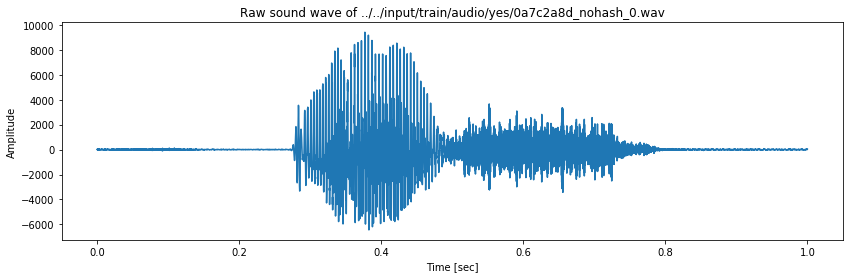

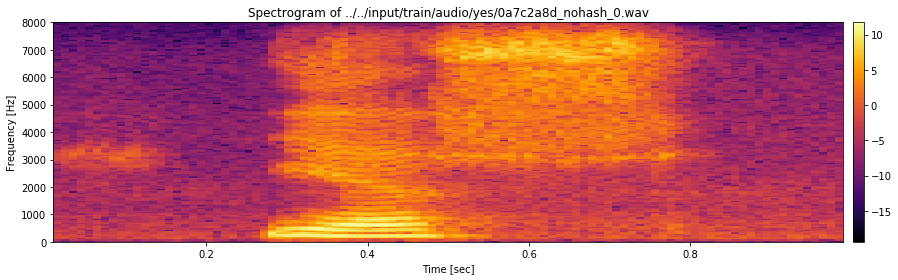

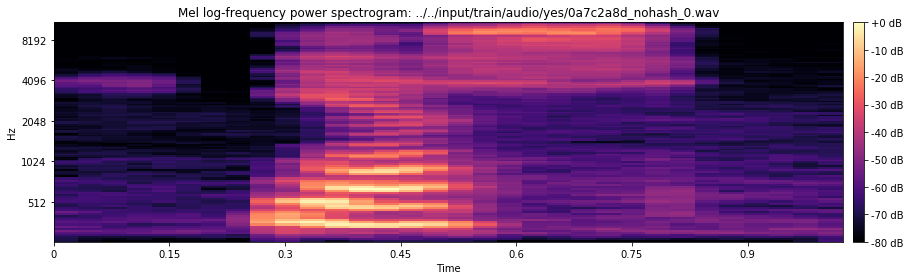

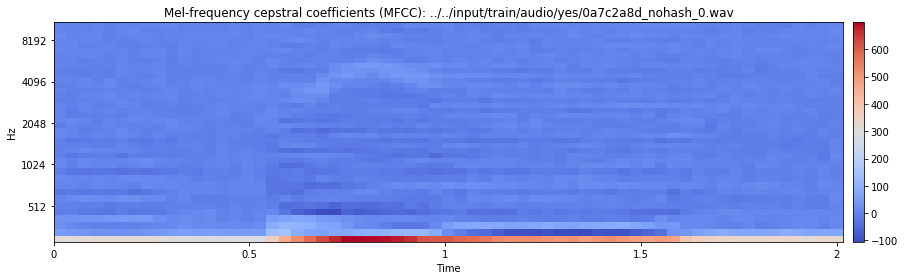

In [16]:
sampleRate, samples, logSpectrogram, logMelSpectrogram, mfcc = showWavefile(filename)

In [17]:
ipd.Audio(filename)

## wave 2

(40, 63)


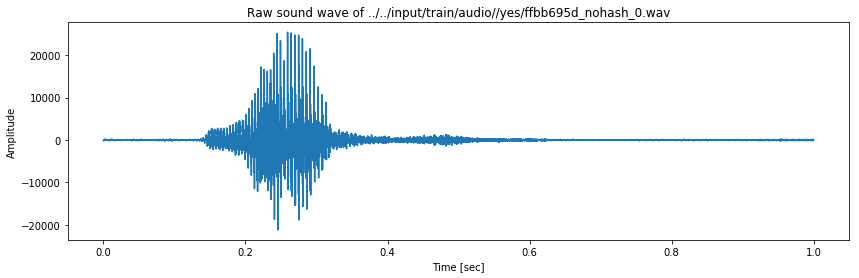

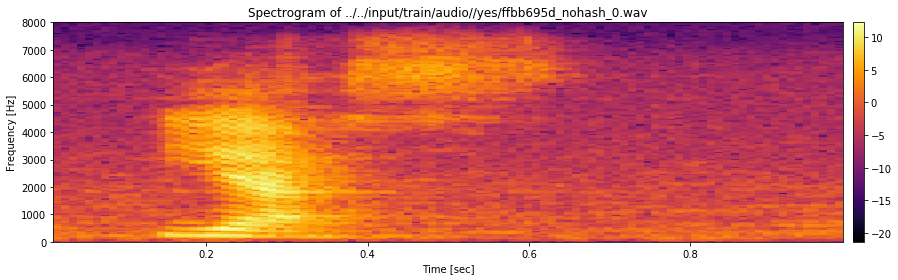

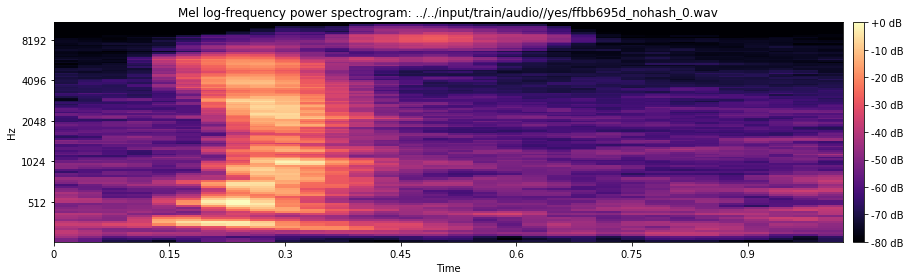

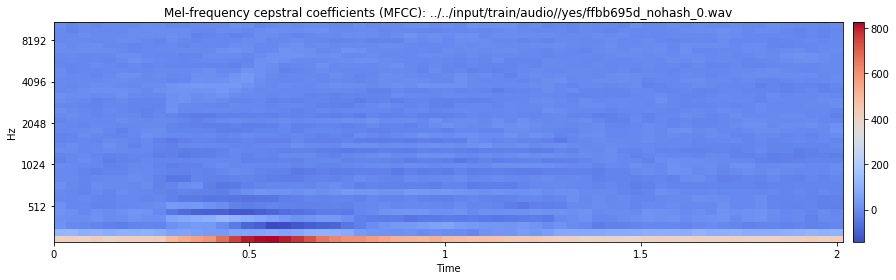

In [18]:
filename2 = str(train_audio_path) + '/yes/ffbb695d_nohash_0.wav'
sampleRate, samples, logSpectrogram, logMelSpectrogram, mfcc = showWavefile(filename2)

In [19]:
ipd.Audio(filename2)

# Spectrogram in 3D

Does not display correctly on GitHub

In [20]:
sampleRate, samples = wavfile.read(filename) 
freqs, times, logSpectrogram = computeLogSpectrogram(samples, sampleRate)

In [21]:
data = [go.Surface(z=logSpectrogram.T)]
layout = go.Layout(
    title='Specgtrogram of "yes" in 3d',
    scene = dict(
    yaxis = dict(title='Frequencies', range=freqs),
    xaxis = dict(title='Time', range=times),
    zaxis = dict(title='Log amplitude'),
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)